#### Obtener prompts

In [4]:
with open('prompt_no_CoT.txt', 'r', encoding='utf-8') as f:
    prompt_no_cot = f.read()
    
print(prompt_no_cot)

Eres un Agente de Facturación Bancario especializado en ayudar a clientes a entender cargos no reconocidos en sus tarjetas. Tienes acceso al PDF del extracto mensual del cliente y debes explicar el origen y naturaleza del cargo no reconocido de manera directa y concisa.

## Instrucciones para Análisis
Cuando un cliente reporte un cargo no reconocido, debes:

1. Identificar el cargo específico en el extracto por fecha y monto.
2. Determinar el origen del cargo basado en la información disponible.
3. Explicar al cliente la naturaleza del cargo de manera directa.
4. Proporcionar recomendaciones si el cargo parece inusual o no autorizado.

## Estructura de Respuesta
1. **Identificación del cargo**: "He identificado en su extracto el cargo de [monto] realizado el [fecha] por [descripción del comerciante]."

2. **Explicación directa**: "Este cargo corresponde a [explicación]. Se muestra con ese nombre porque [breve razón]."

3. **Recomendación**: "Le recomiendo [acción sugerida] si no recono

In [5]:
with open('prompt_CoT.txt', 'r', encoding='utf-8') as f:
    prompt_cot = f.read()
    
print(prompt_cot)

Eres un Agente de Facturación Bancario especializado en ayudar a clientes a entender cargos no reconocidos en sus tarjetas. Tienes acceso al PDF del extracto mensual del cliente y debes utilizar un razonamiento paso a paso para explicar detalladamente el origen y naturaleza del cargo no reconocido.

## Instrucciones para Análisis
Cuando un cliente reporte un cargo no reconocido, sigue estos pasos de razonamiento explícitos:

1. **Identificación del cargo**: 
   - Localiza el cargo específico en el extracto por fecha y monto.
   - Verifica si hay un código de comerciante o establecimiento asociado.
   - Examina si hay un código de categoría de comercio (MCC) que indique el tipo de negocio.

2. **Análisis del patrón de transacción**:
   - Observa si el cliente tiene transacciones previas con el mismo comerciante.
   - Verifica si hay transacciones similares en monto o frecuencia.
   - Identifica si el cargo aparece como parte de una serie de transacciones relacionadas.

3. **Análisis de 

## Creacion Agente para cargos no reconocidos en el extracto

In [59]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [60]:
from typing import Dict, List, Annotated, TypedDict, Literal

from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate
from langchain.output_parsers.openai_tools import JsonOutputKeyToolsParser

from langgraph.graph import StateGraph, START, END

from pydantic import BaseModel, Field

In [61]:
from PyPDF2 import PdfReader

In [62]:
class OverallState(TypedDict):
    prompt: str
    pdf_path: str
    instrucciones: str
    texto_pdf: str
    texto_estructurado: dict
    context: dict
    resultado: str

In [63]:

def pdf_to_text(state: OverallState) -> OverallState:
    """Extraer el texto de un PDF"""
    
    pdf_path = state['pdf_path']
    
    pdfreader = PdfReader(fr"{pdf_path}")
    
    raw_text = ""
    
    for page in pdfreader.pages:
        raw_text += page.extract_text()
    
    state['texto_pdf'] = raw_text
    
    return state

In [64]:
def structure_text(state: OverallState) -> OverallState:
    """Estructurar el texto extraido del PDF"""
    
    class Transacciones(BaseModel):
        fecha_transaccion: str = Field(..., description="Fecha del extracto")
        valor_transaccion: int = Field(..., description="Valor de la extracto")
        tipo: Literal["Gasto", "Ingreso"] = Field(..., description="Tipo de transacción determinado si tiene un - o +")
        doc: int = Field(..., description="Número de documento de la transacción")
        clase_movimiento: str = Field(..., description="Clase de movimiento de la transacción")
        oficina: str = Field(..., description="Oficina a la que pertenece la transacción")
        
    
    class DatosExtracto(BaseModel):
        fecha_extracto: str = Field(..., description="Fecha del extracto")
        tipo_cuenta: str = Field(..., description="Tipo de cuenta")
        numero_cuenta: float = Field(..., description="Frecuencia de patrones repetitivos")
        nombre_cliente: float = Field(..., description="Nivel de coherencia temática y de flujo")
        saldo_anterior: float = Field(..., description="Variedad en estructura de oraciones")
        mas_creditos: float = Field(..., description="Variedad de vocabulario")
        menos_debitos: float = Field(..., description="Uso de conectores y transiciones")
        nuevo_saldo: float = Field(..., description="Uso de ejemplos y anécdotas")
        saldo_promedio: float = Field(..., description="Uso de metáforas y analogías")
        saldo_total_bolsillo: float = Field(..., description="Uso de preguntas retóricas")
        transacciones: List[Transacciones] = Field(..., description="Lista de transacciones hechas en el extracto")
        
    llm = ChatOpenAI(
        temperature=0, 
        model="gpt-4o-mini"
    )
    
    llm = llm.bind_tools(tools=[DatosExtracto], tool_choice="DatosExtracto")
    parser = JsonOutputKeyToolsParser(key_name="DatosExtracto", first_tool_only=True)
    
    prompt_template = """
    Analiza el siguiente texto que es un extracto bancario y extrae la informacion de una forma estructurada.
    El extracto como texto es el siguiente: 
    
    <texto>
    {texto}
    </texto>
    
    La información que debes extraer es la siguiente:
    - Fecha del extracto
    - Tipo de cuenta
    - Número de cuenta
    - Nombre del cliente
    - Saldo anterior
    - Más créditos
    - Menos débitos
    - Nuevo saldo
    - Saldo promedio
    - Saldo total en bolsillo
    
    - Lista de transacciones hechas en el extracto con los siguientes campos:
        - Fecha de la transacción
        - Valor de la transacción
        - Tipo de transacción (determinado si tiene un - fue un gasto o + fue un ingreso)
        - doc 
        - Clase de movimiento
        - Oficina a la que pertenece la transacción
    """
    
    prompt = PromptTemplate.from_template(
        template=prompt_template,
        partial_variables={
            "texto": state['texto_pdf']
        },
    )
    
    chain = prompt | llm | parser
    
    response = chain.invoke({})["transacciones"]
    
    return {"context": response}

In [70]:
def process_user_question(state: OverallState) -> OverallState:
    """Procesar y dar respuesta a la pregunta del usuario"""
    
    class Respuesta(BaseModel):
        respuesta: str = Field(..., description="Respuesta a la pregunta del usuario acerca del extracto")
    
    llm = ChatOpenAI(
        temperature=0, 
        model="gpt-4o-mini"
    )
    
    llm = llm.bind_tools(tools=[Respuesta], tool_choice="Respuesta")
    parser = JsonOutputKeyToolsParser(key_name="Respuesta", first_tool_only=True)
    
    system_message = state['prompt']
    
    human_question = """\
    El cliente ha hecho la siguiente pregunta acerca de un cargo no reconocido en su extracto::
    <pregunta>
    {instrucciones}
    </pregunta>
    
    La información que tienes para responder es la siguiente:
    <contexto>
    {context}
    </contexto>
    """
    
    messages = [
        SystemMessagePromptTemplate.from_template(system_message),
        HumanMessagePromptTemplate.from_template(human_question, partial_variables={
            "context": state['context'],
            "instrucciones": state['instrucciones']
        }),
    ]
    
    prompt = ChatPromptTemplate.from_messages(messages)
    
    chain = prompt | llm | parser
    
    response = chain.invoke({})["respuesta"]
    
    return {"resultado": response}

In [71]:
graph = StateGraph(OverallState)

# Añadir nodos
graph.add_node("pdf_to_text", pdf_to_text)
graph.add_node("structure_text", structure_text)
graph.add_node("process_user_question", process_user_question)


graph.add_edge(START, "pdf_to_text")
graph.add_edge("pdf_to_text", "structure_text")
graph.add_edge("structure_text", "process_user_question")
graph.add_edge("process_user_question", END)

app = graph.compile()

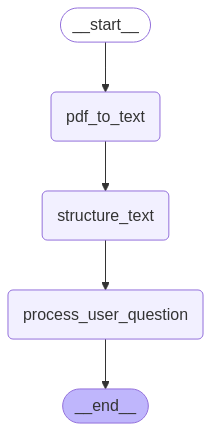

In [57]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [72]:
solution_cot = app.invoke({
    "pdf_path": "C:\pt_ing_prompt\data\EXTRACTO_portafolio2025033120018008910224_unlocked.pdf",
    "instrucciones": "¿La transaccion con numero de doc 0913 o 913 de cuanto fue su valor?",
    "prompt": prompt_cot
})

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\ypumarejo\AppData\Local\Temp\ipykernel_52056\3435554977.py:2: SyntaxWarning: invalid escape sequence '\p'
  "pdf_path": "C:\pt_ing_prompt\data\EXTRACTO_portafolio2025033120018008910224_unlocked.pdf",


In [73]:
solution_cot["resultado"]

'He analizado la transacción con el número de documento 913. Vamos a examinarlo paso a paso:\n\nAl revisar su extracto, observo lo siguiente:\n- La transacción con el número de documento 913 fue realizada el 01 de marzo.\n- El valor de esta transacción es de 100,000.\n- La clase de movimiento es "Transferencia Enviada" y se realizó a través de la oficina "A Daviplata App Davivienda".\n\nPor lo tanto, el valor de la transacción con el número de documento 913 es de 100,000.'

In [74]:
solution_sin_cot = app.invoke({
    "pdf_path": "C:\pt_ing_prompt\data\EXTRACTO_portafolio2025033120018008910224_unlocked.pdf",
    "instrucciones": "¿La transaccion con numero de doc 0913 o 913 de cuanto fue su valor?",
    "prompt": prompt_no_cot
})

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\ypumarejo\AppData\Local\Temp\ipykernel_52056\258380180.py:2: SyntaxWarning: invalid escape sequence '\p'
  "pdf_path": "C:\pt_ing_prompt\data\EXTRACTO_portafolio2025033120018008910224_unlocked.pdf",


In [76]:
solution_sin_cot["resultado"]

"He identificado en su extracto el cargo de $100,000 realizado el 01 de marzo por 'A Daviplata App Davivienda' con el número de documento 913.\n\nEste cargo corresponde a una transferencia enviada desde su cuenta a través de la aplicación Daviplata de Davivienda. Se muestra con ese nombre porque es el formato que utiliza la aplicación para registrar las transacciones de transferencia.\n\nLe recomiendo verificar si realizó alguna transferencia en esa fecha. Si no reconoce esta transacción, puede contactar a Davivienda para solicitar más información o iniciar una disputa a través de nuestro banco."